In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from numpy.fft import fft, fftfreq
from scipy import stats
sns.set()

In [116]:
# Load the dataset
file_path = "acquisitions/synthetic_test/processed/processed_all_actions.csv"

# Import the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [117]:
data.head()

,_time,series_id,measurement_id,action,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z,quat_x,quat_y,quat_z,quat_w
0,2023-12-29 16:50:56.247487,0,0,floating_x,1.865854,0.323171,0.243902,0.004321,-0.004956,0.010840,-0.7,0.68,0.21,0.1
1,2023-12-29 16:50:56.262481,0,1,floating_x,1.865854,0.323171,0.243902,0.004321,-0.004956,0.010840,-0.7,0.68,0.21,0.1
2,2023-12-29 16:50:56.276026,0,2,floating_x,1.743902,-0.164634,0.182927,0.004077,0.000659,0.006201,-0.7,0.68,0.21,0.1
3,2023-12-29 16:50:56.291837,0,3,floating_x,0.280488,-1.506098,0.243902,0.003345,-0.003735,-0.007471,-0.7,0.68,0.21,0.1
4,2023-12-29 16:50:56.306791,0,4,floating_x,-0.878049,-1.567073,-0.060976,0.004565,-0.008130,-0.011377,-0.7,0.68,0.21,0.1


In [118]:
data.describe()

,series_id,measurement_id,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z,quat_x,quat_y,quat_z,quat_w
count,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000
mean,5.216951,170.265259,-4.114510,0.755942,-0.869745,-0.106049,-0.097238,0.046940,0.051449,0.272953,0.070223,0.254709
std,3.722790,121.300390,71.090067,74.537029,65.122563,0.437289,0.338756,0.441120,0.630403,0.530645,0.357432,0.216536
min,0.000000,0.000000,-777.884146,-337.158537,-232.682927,-1.948242,-2.094897,-0.991528,-0.980000,-0.980000,-0.990000,0.000000
25%,2.000000,72.000000,-8.073171,-9.926829,-15.280488,-0.266504,-0.099365,-0.023169,-0.610000,-0.210000,-0.170000,0.070000
50%,5.000000,149.000000,0.146341,0.030488,-0.146341,-0.001611,-0.008472,0.007153,0.210000,0.530000,0.100000,0.180000
75%,9.000000,248.000000,15.128049,10.182927,6.024390,0.033301,0.009595,0.091650,0.640000,0.690000,0.320000,0.430000
max,11.000000,500.000000,203.975610,576.463415,715.134146,1.710742,0.819019,2.023047,0.990000,0.990000,1.000000,0.970000


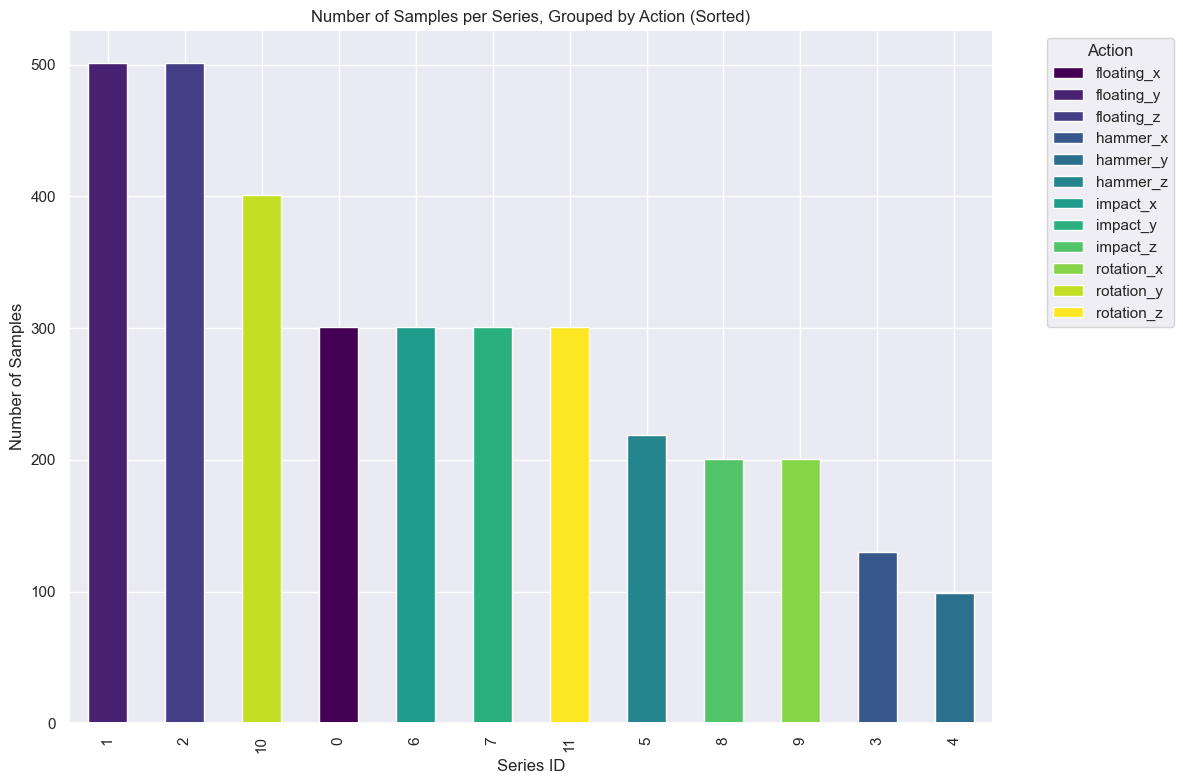

In [119]:
# Grouping data by series_id and action
grouped_data = data.groupby(['series_id', 'action']).size().unstack(fill_value=0)

# Sorting the grouped data by the total number of samples in each series, from highest to lowest
sorted_grouped_data = grouped_data.sum(axis=1).sort_values(ascending=False)
sorted_grouped_data = grouped_data.loc[sorted_grouped_data.index]

# Plotting the sorted histogram
ax = sorted_grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Number of Samples per Series, Grouped by Action (Sorted)')
plt.xlabel('Series ID')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_axisbelow(True)
plt.tight_layout()
plt.show()

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   _time           3457 non-null   object 
 1   series_id       3457 non-null   int64  
 2   measurement_id  3457 non-null   int64  
 3   action          3457 non-null   object 
 4   gyro_x          3457 non-null   float64
 5   gyro_y          3457 non-null   float64
 6   gyro_z          3457 non-null   float64
 7   accel_x         3457 non-null   float64
 8   accel_y         3457 non-null   float64
 9   accel_z         3457 non-null   float64
 10  quat_x          3457 non-null   float64
 11  quat_y          3457 non-null   float64
 12  quat_z          3457 non-null   float64
 13  quat_w          3457 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 378.2+ KB


In [121]:
# function to calculate correlation matrix of one series
def plot_correlation_matrix(data, action):

    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Filter data for the specific series_id and action
    filtered_data = data[(data['series_id'] == series_id) & (data['action'] == action)]
    # Select only float columns
    numeric_data = filtered_data.select_dtypes(include=[np.float64])

    # Calculate the correlation matrix
    corr_matrix = numeric_data.corr()

    # Plotting the heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f'Correlation Matrix for Series ID {series_id} and Action {action}')
    plt.show()

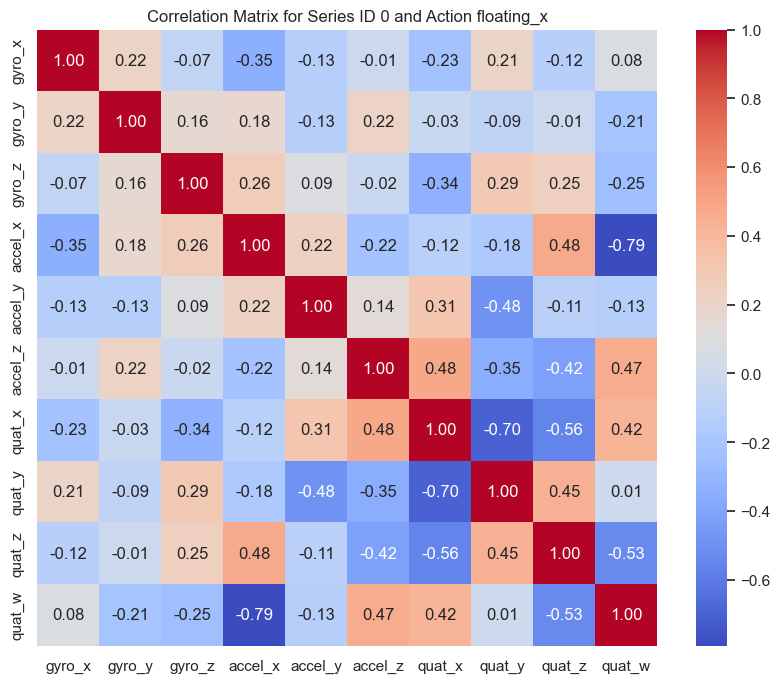

In [122]:
plot_correlation_matrix(data,'floating_x')

In [123]:
# Convert '_time' to datetime and calculate time differences
data['_time'] = pd.to_datetime(data['_time'])
data['time_diff'] = data.groupby('series_id')['_time'].diff()

# Dropping NaN values
data_cleaned = data.dropna()

# Converting the time differences from timedelta to float (in seconds) for easier plotting
data_cleaned['time_diff_seconds'] = data_cleaned['time_diff'].dt.total_seconds()

C:\Users\Marco\AppData\Local\Temp\ipykernel_15816\3005622164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['time_diff_seconds'] = data_cleaned['time_diff'].dt.total_seconds()


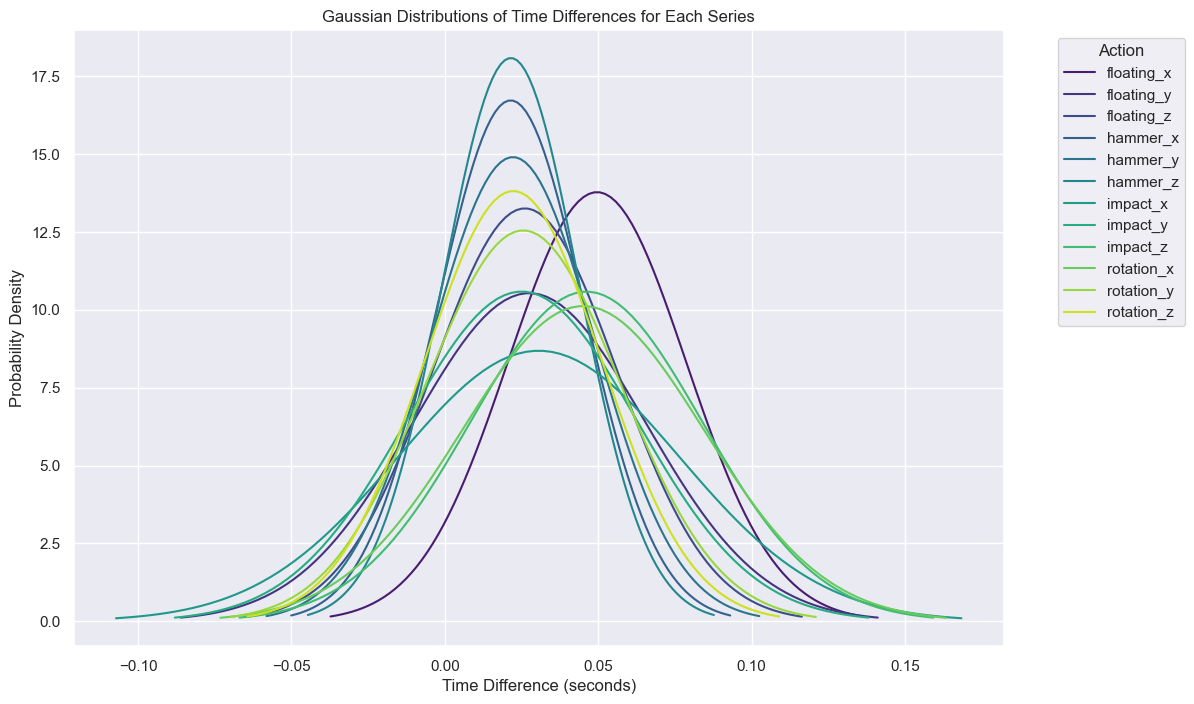

In [124]:
# Create a mapping of series_id to action
action_mapping = data_cleaned.dropna().groupby('series_id')['action'].first().to_dict()

# Setting up the color palette to match the histogram colors
palette = sns.color_palette('viridis', n_colors=len(data_cleaned['series_id'].unique()))

# Plotting Gaussian distributions with the same colors as the histogram
plt.figure(figsize=(12, 8))

# Generating Gaussian plots for each series
for idx, series_id in enumerate(sorted(data_cleaned['series_id'].unique())):
    # Selecting the series
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]['time_diff_seconds']
    
    # Calculating mean and standard deviation
    mean = series_data.mean()
    std = series_data.std()
    
    # Generating points for the Gaussian curve
    x = np.linspace(mean - 3*std, mean + 3*std, 100)
    y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    
    # Plotting with action name in the label
    action_name = action_mapping.get(series_id, 'Unknown')
    plt.plot(x, y, label=f'{action_name}', color=palette[idx])

# Adding title, labels, and legend
plt.title('Gaussian Distributions of Time Differences for Each Series')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Probability Density')
plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# show bar on top of grid
plt.gca().set_axisbelow(True)
# Show plot
plt.show()


In [125]:
# print the mean and standard deviation of the time differences for each series
series_mean = []
series_std = []

for series_id in data_cleaned['series_id'].unique():
    series_data = data_cleaned[data_cleaned['series_id'] == series_id]['time_diff_seconds']
    series_mean.append(series_data.mean())
    series_std.append(series_data.std())
    print(f'Series {series_id}: mean = {series_data.mean()}, std = {series_data.std()}')

print('-------------------')

# print minimum and maximum mean and standard deviation
print(f'Minimum mean: {min(series_mean)}')
print(f'Maximum mean: {max(series_mean)}')
print(f'Minimum std: {min(series_std)}')
print(f'Maximum std: {max(series_std)}')

print('-------------------')

sampling_time = round(min(series_mean), 2)
print(f'Sampling time: {sampling_time} seconds')

Series 0: mean = 0.04959692666666667, std = 0.028955342144013397
Series 1: mean = 0.027511970000000004, std = 0.03786846571124512
Series 2: mean = 0.026084467999999996, std = 0.030094336600227485
Series 3: mean = 0.021462023255813957, std = 0.023854636349822385
Series 4: mean = 0.022189438775510207, std = 0.026768706263315695
Series 5: mean = 0.021507, std = 0.022060028831696925
Series 6: mean = 0.030586783333333336, std = 0.045933133781250725
Series 7: mean = 0.025045226666666667, std = 0.037686705165563036
Series 8: mean = 0.046150395, std = 0.037697013358883945
Series 9: mean = 0.045073755, std = 0.03941988182925128
Series 10: mean = 0.025535295000000003, std = 0.03179207141750147
Series 11: mean = 0.022298380000000003, std = 0.028880091391560433
-------------------
Minimum mean: 0.021462023255813957
Maximum mean: 0.04959692666666667
Minimum std: 0.022060028831696925
Maximum std: 0.045933133781250725
-------------------
Sampling time: 0.02 seconds


In [249]:
def oversample_dataset(data, sample_time):
    # Empty DataFrame to store the oversampled data
    oversampled_data = pd.DataFrame()

    # Remove time_diff column
    data = data.drop(columns=['time_diff'], errors='ignore')

    # Get the length of each series after resampling
    series_length = []

    # Iterate over each series to calculate its length after resampling
    for series_id in data['series_id'].unique():
        # Filter and resample the data for the current series
        series_data = data[data['series_id'] == series_id]
        numeric_data = series_data.select_dtypes(include=[np.number, 'datetime64[ns]'])
        resampled_data = numeric_data.resample(f'{sample_time}S', on='_time').mean()
        series_length.append(len(resampled_data))

    # Calculate the length of the longest series
    max_length = max(series_length)

    # Iterate over each series again to pad them
    for series_id, length in zip(data['series_id'].unique(), series_length):
        # Filter and resample the data for the current series
        series_data = data[data['series_id'] == series_id]
        numeric_data = series_data.select_dtypes(include=[np.number, 'datetime64[ns]'])
        resampled_data = numeric_data.resample(f'{sample_time}S', on='_time').mean().interpolate(method='linear', limit_direction='both')

        # Pad the series if it is shorter than the longest series
        if length < max_length:
            padding_length = max_length - length
            padding_df = pd.DataFrame(0.0, index=np.arange(padding_length), columns=resampled_data.columns)
            padding_df['series_id'] = series_id  # Set series_id for the padding
            resampled_data = pd.concat([resampled_data, padding_df], ignore_index=True)

        # Refactor measurement_id to be sequential for each series_id
        resampled_data['measurement_id'] = np.arange(len(resampled_data))

        # Append the processed series data to the oversampled_data DataFrame
        oversampled_data = pd.concat([oversampled_data, resampled_data], ignore_index=True)

        # convert series_id to int
        oversampled_data['series_id'] = oversampled_data['series_id'].astype(int)
        
        # add action column based on the action mapping
        oversampled_data['action'] = oversampled_data['series_id'].map(action_mapping)

    # Return the oversampled dataset
    return oversampled_data

In [250]:
oversample_data = oversample_dataset(data, sampling_time)

In [251]:
oversample_data

,series_id,measurement_id,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z,quat_x,quat_y,quat_z,quat_w,action
0,0,0,1.865854,0.323171,0.243902,0.004321,-0.004956,0.010840,-0.7,0.68,0.21,0.1,floating_x
1,0,1,1.804878,0.079268,0.213415,0.004199,-0.002148,0.008521,-0.7,0.68,0.21,0.1,floating_x
2,0,2,0.280488,-1.506098,0.243902,0.003345,-0.003735,-0.007471,-0.7,0.68,0.21,0.1,floating_x
3,0,3,-0.878049,-1.567073,-0.060976,0.004565,-0.008130,-0.011377,-0.7,0.68,0.21,0.1,floating_x
4,0,4,-1.162602,-0.611789,-0.467480,0.000618,-0.002922,-0.007878,-0.7,0.68,0.21,0.1,floating_x
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8935,11,740,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,rotation_z
8936,11,741,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,rotation_z
8937,11,742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,rotation_z
8938,11,743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00,0.0,rotation_z


In [252]:
feature_plot = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']

# function to plot acceleration data for a given series
def plot_acceleration_data(data, action):
    
    # Getting the series ID for the action
    series_id = data[data['action'] == action]['series_id'].iloc[0]
    # Selecting the series
    series_data = data[data['series_id'] == series_id]
    
    # Plotting the acceleration data in a 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))
    fig.suptitle(f'Acceleration Data for Series {series_id} - {action_mapping.get(series_id, "Unknown")}')

    # Plotting each feature
    for idx, feature in enumerate(feature_plot):
        # Calculating the row and column index
        row = idx // 3
        col = idx % 3
        
        color_plot = 'blue'

        if row == 0:
            axs[row, col].set_ylabel('Acceleration (g)')
        else:
            axs[row, col].set_ylabel('Angular Velocity (deg/s)')

        if col == 0:
            # make plot color blue
            color_plot = 'C0'
        elif col == 1:
            # make plot color orange
            color_plot = 'C1'
        else:
            # make plot color green
            color_plot = 'C2'

        # Plotting the feature
        axs[row, col].plot(series_data['measurement_id'], series_data[feature], color=color_plot)
        axs[row, col].set_title(feature)
        axs[row, col].set_xlabel('Measurement ID')
        axs[row, col].grid(True)
        axs[row, col].set_axisbelow(True)      

    # Adjusting the spacing between plots
    fig.tight_layout(pad=3.0)

    # Show plot
    plt.show()

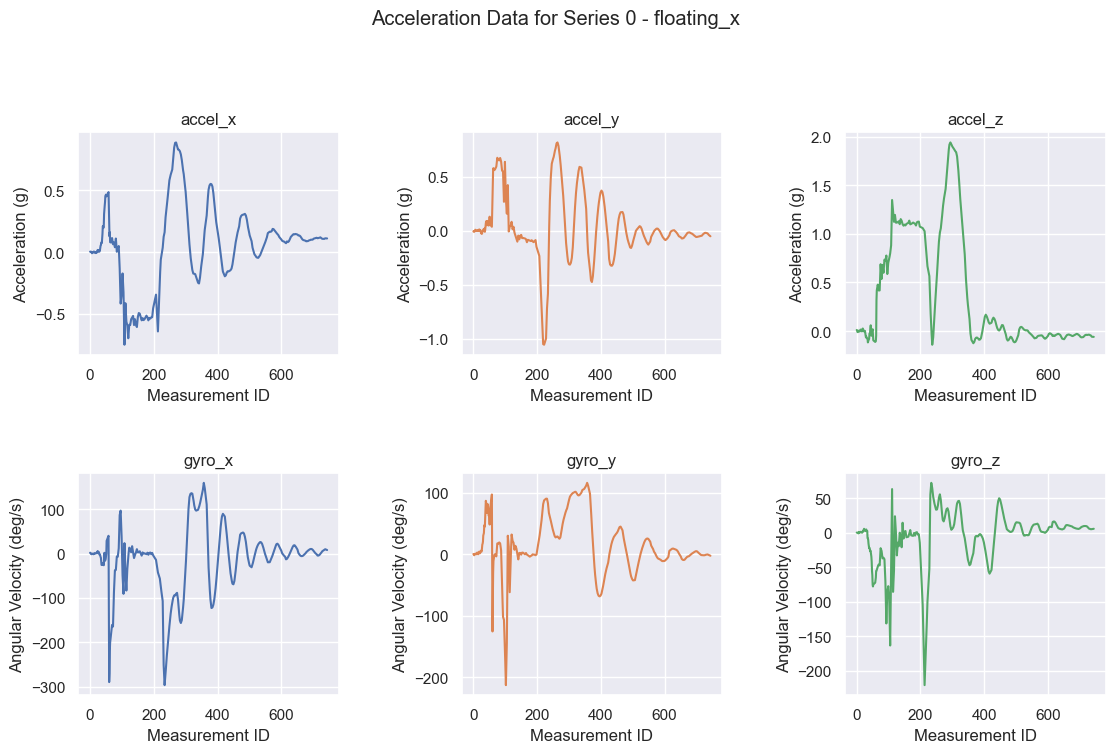

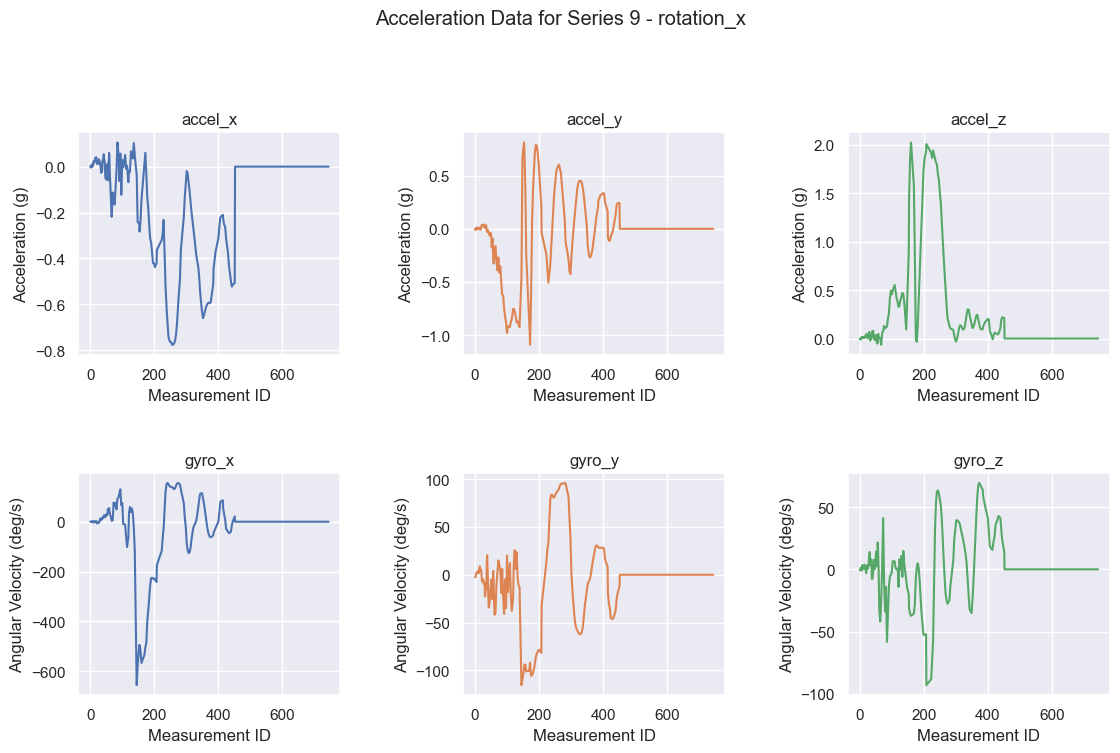

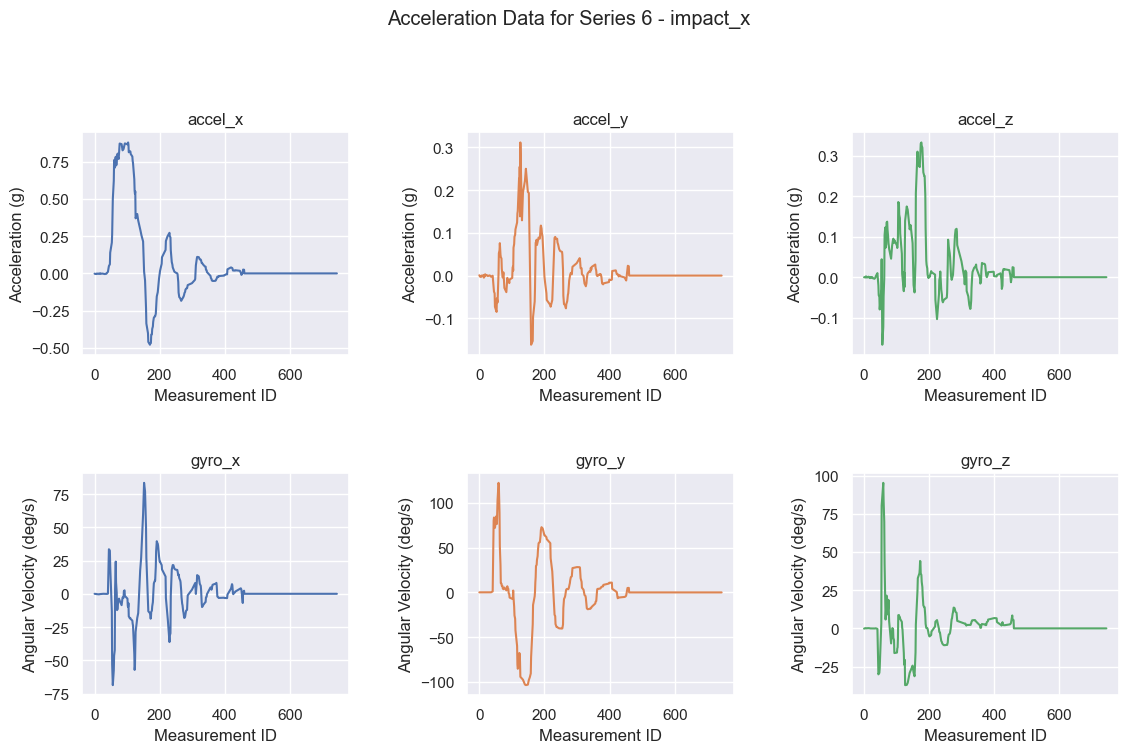

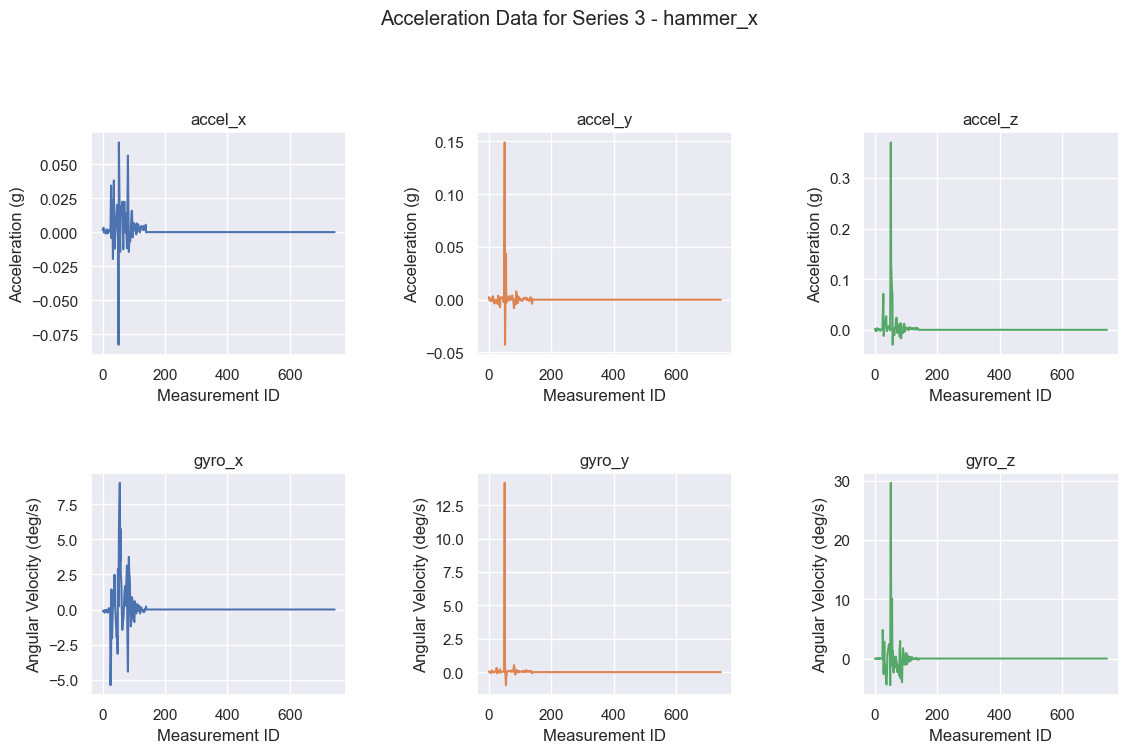

In [254]:
plot_acceleration_data(oversample_data, 'floating_x')
plot_acceleration_data(oversample_data, 'rotation_x')
plot_acceleration_data(oversample_data, 'impact_x')
plot_acceleration_data(oversample_data, 'hammer_x')

In [ ]:
# function to oversample the data
